In [63]:
#imports
import kagglehub
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from pathlib import Path
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython.display as ipd
import seaborn as sns
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import KFold

In [4]:
# Descarga del dataset de Urban Sound
path = kagglehub.dataset_download("rupakroy/urban-sound-8k")
print("Path to dataset files:", path)

100%|██████████| 5.61G/5.61G [10:32<00:00, 9.53MB/s]

Extracting files...


Path to dataset files: C:\Users\maria\.cache\kagglehub\datasets\rupakroy\urban-sound-8k\versions\1


In [44]:
data = pd.read_csv(path + "/UrbanSound8K.csv")
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# Mostrar una waveform  y un spectrograma random

Class : children_playing



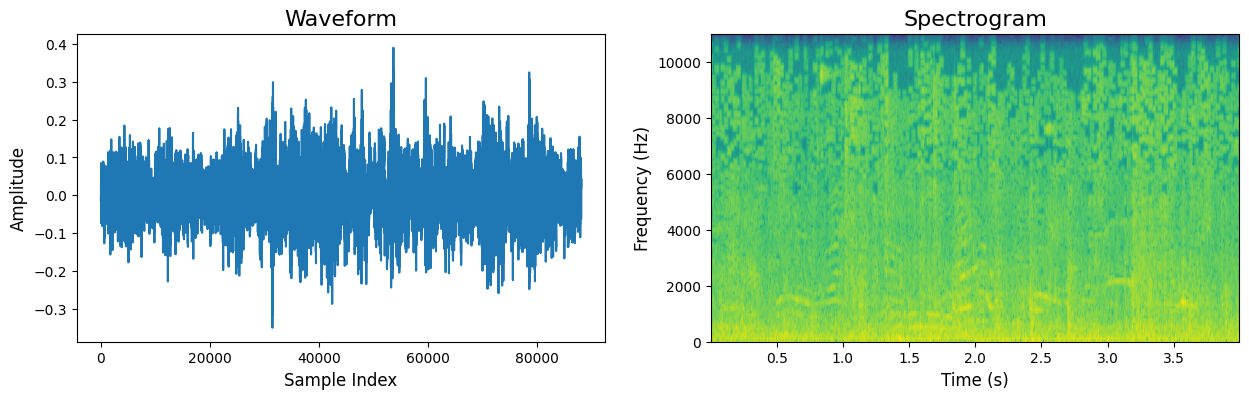

In [ ]:
# Seleccionar una fila aleatoria
row = data.sample(1).iloc[0]

# Ruta del archivo de audio
audioFile = os.path.join(path + "/UrbanSound8K/audio", 'fold' + str(row['fold']), row['slice_file_name'])

# Cargar audio
waveform, sampleRate = librosa.load(audioFile)

# Mostrar información
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Mostrar waveform y espectrograma
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Espectrograma
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

# Modelo 1

## Preprocesamiento de Datos

In [ ]:
# Directorio de los audios
audio_dir = Path(path) / 'UrbanSound8K/audio'

# Cargar las etiquetas desde el archivo CSV
metadata = pd.read_csv(Path(path) / 'UrbanSound8K.csv')

# Crear un directorio para guardar los espectrogramas
output_dir = Path('UrbanSound_Spectrograms')
output_dir.mkdir(exist_ok=True, parents=True)

def generate_and_save_mel_spectrogram(audio_path, output_path, sr=22050, n_mels=128):
    # Cargar el archivo de audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Generar el espectrograma de Mel
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    
    # Convertir a escala logarítmica
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    plt.figure(figsize=(2.56, 2.56))  # tamaño adecuado para que sea cuadrado 256x256 píxeles
    librosa.display.specshow(mel_spect_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')  # quita los ejes para que sea una imagen limpia
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Recorrer el archivo CSV para cada archivo de audio y generar el espectrograma
for index, row in metadata.iterrows():
    fold = row['fold']
    class_id = row['classID']
    file_name = row['slice_file_name']
    
    # Ruta del archivo de audio
    audio_path = audio_dir / f'fold{fold}' / file_name
    # Directorio de salida por clase
    class_dir = output_dir / str(class_id)
    class_dir.mkdir(exist_ok=True, parents=True)
    
    # Ruta de salida para el espectrograma
    output_path = class_dir / f"{file_name.replace('.wav', '.png')}"
    
    # Generar y guardar el espectrograma
    generate_and_save_mel_spectrogram(audio_path, output_path)
    print(f"Espectrograma guardado en: {output_path}")

Espectrograma guardado en: UrbanSound_Spectrograms\3\100032-3-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-117.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-121.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-126.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-137.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-143.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-161.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-36.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-3-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-4-0.png
Espectr

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\17307-1-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-1.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-10.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-11.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-17.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-2.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-7.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-25.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-39.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-51.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-52.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-14.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-44.png
Espectrogram

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-3-0.png


c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-4-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-5-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\6\87562-6-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-1.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-2.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\7\88466-7-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-14.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-21.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-36.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-54.png
Espectrograma guardado en: Urb

## Entrenamiento del Modelo

Configuracion del dataset para entrenamiento de keras.

In [18]:
# Definimos el tamaño de las imágenes y el batch size
img_height, img_width = 128, 128
batch_size = 32

# Definimos el generador de datos para aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% para entrenamiento y 20% para validación
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6988 images belonging to 10 classes.
Found 1744 images belonging to 10 classes.


Diseño de CNN

In [19]:
# Definimos el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Regularización para reducir el overfitting
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout más alto en la capa densa final para regularizar aún más
    
    Dense(10, activation='softmax')  # 10 clases de sonidos urbanos
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostramos el resumen de la arquitectura del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo

In [21]:
# Número de épocas para entrenamiento
epochs = 20

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 692s 3s/step - accuracy: 0.1813 - loss: 2.1973 - val_accuracy: 0.2743 - val_loss: 1.9902
Epoch 2/20
  1/218 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.3125 - loss: 1.9125

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3125 - loss: 1.9125 - val_accuracy: 0.1875 - val_loss: 1.9860
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.2724 - loss: 1.9618 - val_accuracy: 0.2951 - val_loss: 1.9229
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4062 - loss: 1.7559 - val_accuracy: 0.3750 - val_loss: 1.6728
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.3614 - loss: 1.7833 - val_accuracy: 0.3779 - val_loss: 1.6795
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1875 - loss: 2.3274 - val_accuracy: 0.4375 - val_loss: 1.5438
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.4039 - loss: 1.6359 - val_accuracy: 0.4149 - val_loss: 1.5503
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3438 - loss: 1.6303 - val_accuracy: 0.3125 - val_loss: 1.6782
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.4507 - loss: 1.5407 - val_accuracy: 0.4277 -

Evaluacion y resultados

In [22]:
# Evaluación del modelo en los datos de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Accuracy en validación: {val_accuracy * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 896ms/step - accuracy: 0.5440 - loss: 1.2704
Accuracy en validación: 54.53%


## Visualizacion de los Resultados

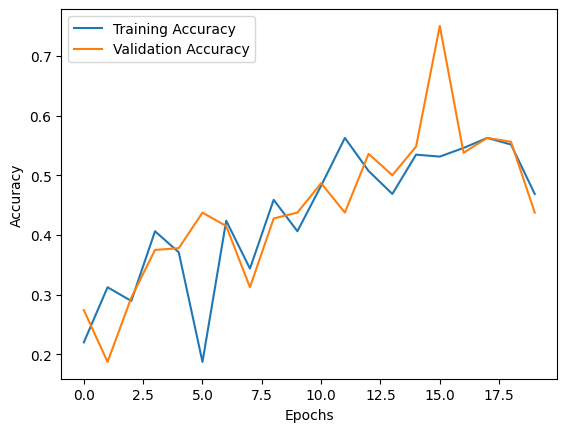

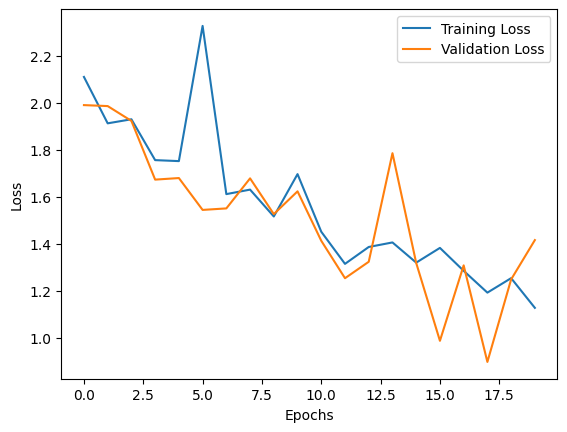

In [23]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modelo 2

## Preprocesamiento de Datos

### Data Augmentation

In [77]:
def augmentData(waveform):
    # Aplicar preénfasis
    waveform = librosa.effects.preemphasis(waveform)
    
    # time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    # Añadir ruido
    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [78]:
# Computar los coeficientes MFCC
def mfccExtract(file):
    # Cargar el archivo de audio
    waveform, sampleRate = librosa.load(file)
    
    # waveform = augmentData(waveform)
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

# Lista para almacenar los datos extraídos
extractAll = []

for index, row in tqdm(data.iterrows()):

    audioFile = os.path.join(path + "/UrbanSound8K/audio", 'fold' + str(row['fold']), row['slice_file_name'])
    
    # Extraer los coeficientes MFCC
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

8732it [17:04,  8.52it/s]


### Feautures

In [79]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head()

,Features,Class
0,"[-211.93698, 62.581207, -122.81315, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043558, 42.78452, 11...",children_playing
4,"[-439.63867, 103.86223, -42.658783, 50.690277,...",children_playing


In [80]:
# Convertir features a un numpy array
x = np.array(featuresDf['Features'].tolist())

# Encoding classes
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 10)

## Cross-Validation

In [81]:
# Parámetros y métricas para cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_accuracies = []
conf_matrices = []

for train_index, test_index in kf.split(x):
    trainX, testX = x[train_index], x[test_index]
    trainY, testY = y[train_index], y[test_index]

## Diseño del Modelo

In [82]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = (64,)),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(10, activation = 'softmax')
])

# Definir el optimizador, función de pérdida y métricas
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 774,314 (2.95 MB)

 Trainable params: 770,282 (2.94 MB)

 Non-trainable params: 4,032 (15.75 KB)

### Callbacks

In [83]:
# Early stopping para evitar el sobreajuste
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [84]:
# Añadir reducción de la tasa de aprendizaje
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

## Entrenamiento del Modelo

In [85]:
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.4374 - loss: 1.7521 - val_accuracy: 0.6564 - val_loss: 1.0489 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.6774 - loss: 1.0123 - val_accuracy: 0.7377 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.7444 - loss: 0.7942 - val_accuracy: 0.7640 - val_loss: 0.7363 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.7917 - loss: 0.6500 - val_accuracy: 0.8099 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.8199 - loss: 0.5431 - val_accuracy: 0.7583 - val_loss: 0.7467 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.8343 - loss: 0.4937 - val_accuracy: 0.8259 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.8

In [86]:
historyDf = pd.DataFrame(history.history)

## Validacion

<Axes: >

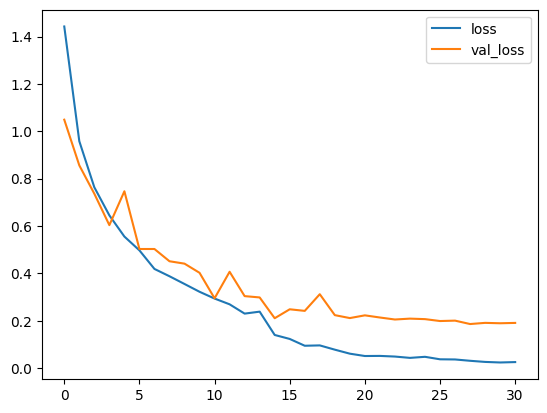

In [87]:
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

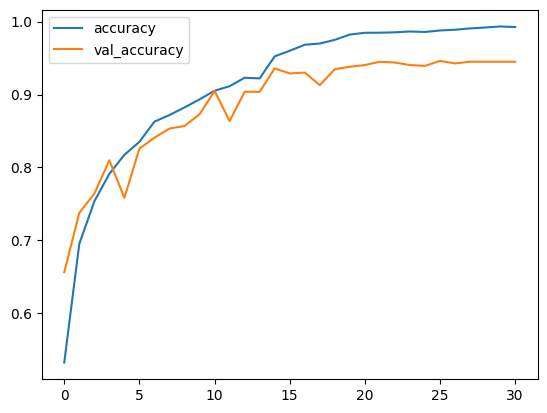

In [88]:
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

## Evaluacion del Modelo

In [89]:
 # Evaluar el modelo en el fold actual
score = model.evaluate(testX, testY, verbose=0)[1] * 100
fold_accuracies.append(score)

In [90]:
print(f"Cross-validation accuracy por fold: {fold_accuracies}")
print(f"Promedio de accuracy en cross-validation: {np.mean(fold_accuracies):.2f}%")

Cross-validation accuracy por fold: [94.61626410484314]
Promedio de accuracy en cross-validation: 94.62%


In [91]:
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9618 - loss: 0.1683
Validation accuracy of model : 94.62%


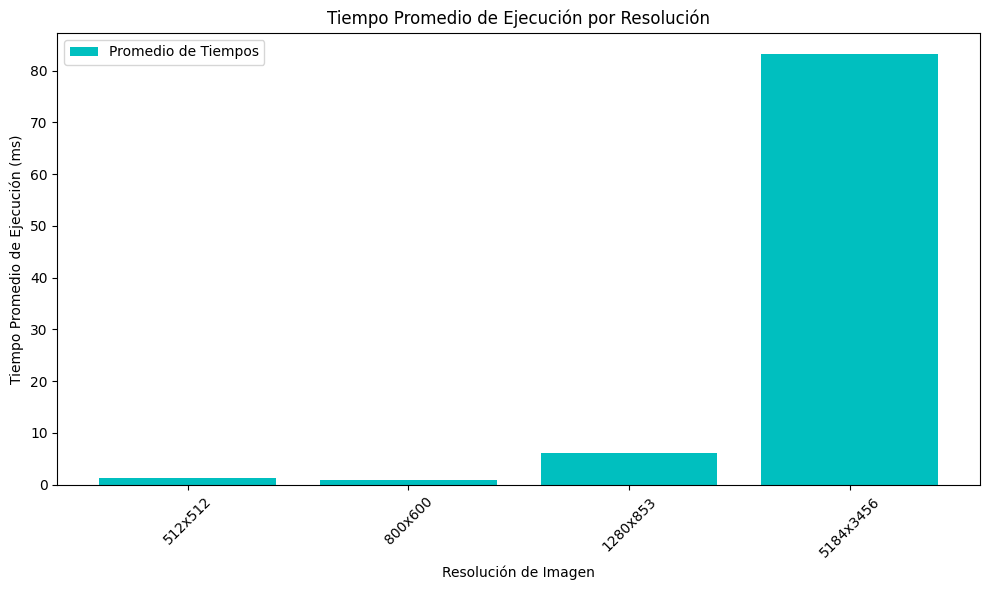

In [7]:
# Datos
resoluciones = ['512x512', '512x512', '800x600', '1280x853', '800x600', '5184x3456']
memoria_global = [1.89952, 1.91866, 1.00352, 9.01939, 1.00352, 118.686]
memoria_global_constante = [1.86397, 1.86675, 0.966656, 8.8023, 0.966656, 118.56]
memoria_global_constante_compartida = [0.188256, 0.188256, 1.00352, 0.75264, 1.00352, 12.204]

# Calcular tiempos promedio por resolución
promedio_tiempos = [
    np.mean([memoria_global[i], memoria_global_constante[i], memoria_global_constante_compartida[i]]) 
    for i in range(len(resoluciones))
]

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(resoluciones, promedio_tiempos, color='c', label='Promedio de Tiempos')

# Personalización
ax.set_xlabel('Resolución de Imagen')
ax.set_ylabel('Tiempo Promedio de Ejecución (ms)')
ax.set_title('Tiempo Promedio de Ejecución por Resolución')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
